In [1]:
import fsspec
import xarray as xr
import os
import matplotlib.pyplot as plt
import fv3viz
import yaml

from vcm.catalog import catalog

grid = catalog['grid/c48'].read()

In [2]:

rad_results_path = "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-06/decrease-rad-lr-rad-flux-ensemble/offline_diags/radiative_fluxes/"

# replace with rerun offline diags after variance bug fix is merged
#tq_results_path = "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-05-17/tapering-effect-mae-no-taper-ensemble/offline_diags/tq_tendencies"
tq_results_path = "gs://vcm-ml-scratch/annak/2022-07-12/offline-diags-fix-zonal-variance"

with fsspec.open(os.path.join(rad_results_path, "offline_diagnostics.nc"), "rb") as f:
    rad_diags = xr.open_dataset(f).load()
    
with fsspec.open(os.path.join(rad_results_path, "transect_lon0.nc"), "rb") as f:
    rad_transect = xr.open_dataset(f).load()
    

with fsspec.open(os.path.join(tq_results_path, "offline_diagnostics.nc"), "rb") as f:
    tq_diags = xr.open_dataset(f).load()
    
with fsspec.open(os.path.join(tq_results_path, "transect_lon0.nc"), "rb") as f:
    tq_transect = xr.open_dataset(f).load()
    


In [3]:
pressure_hpa = tq_diags.pressure/100.


#### Zonal mean $R^2$

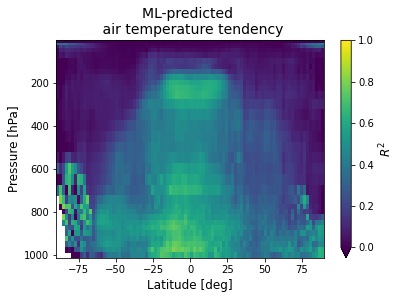

In [6]:
dq1_r2_zonal_avg = tq_diags["dq1_r2_pressure_level_zonal_avg_global"].rename("$R^2$") \
    .assign_coords({"pressure": pressure_hpa}) \
    .rename(
    {
        "pressure": "pressure [hPa]",
        "latitude": "latitude [deg]",
    }
)


f = dq1_r2_zonal_avg.plot(vmin=0., vmax=1., x="latitude [deg]", yincrease=False, )
f.axes.set_xlabel("Latitude [deg]", fontsize=12)
f.axes.set_ylabel("Pressure [hPa]", fontsize=12)
f.colorbar.set_label("$R^2$", fontsize=12)
plt.title("ML-predicted \n air temperature tendency", fontsize=14)

plt.savefig('figures/png/offline_dQ1_R2_zonal_avg.png', dpi=150)
plt.savefig('figures/pdf/offline_dQ1_R2_zonal_avg.pdf', dpi=150)

In [9]:
dq1_r2_zonal_avg.max(), dq2_r2_zonal_avg.max()

(<xarray.DataArray '$R^2$' ()>
 array(0.81015172)
 Coordinates:
     time_snapshot  object 2020-02-06 22:30:00,
 <xarray.DataArray '$R^2$' ()>
 array(0.86607692)
 Coordinates:
     time_snapshot  object 2020-02-06 22:30:00)

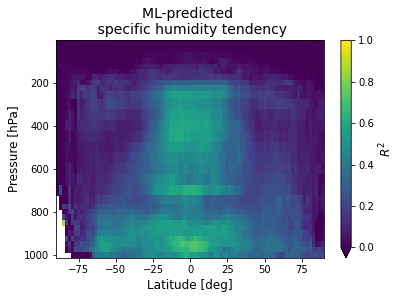

In [7]:
dq2_r2_zonal_avg = tq_diags["dq2_r2_pressure_level_zonal_avg_global"].rename("$R^2$") \
    .assign_coords({"pressure": pressure_hpa}) \
    .rename(
    {
        "pressure": "pressure [hPa]",
        "latitude": "latitude [deg]",
    }
)
    
f = dq2_r2_zonal_avg.plot(vmin=0., vmax=1., x="latitude [deg]", yincrease=False)

f.axes.set_xlabel("Latitude [deg]", fontsize=12)
f.axes.set_ylabel("Pressure [hPa]", fontsize=12)
f.colorbar.set_label("$R^2$", fontsize=12)
plt.title("ML-predicted \n specific humidity tendency", fontsize=14)

plt.savefig('figures/pdf/offline_dQ2_R2_zonal_avg.pdf', dpi=150)
plt.savefig('figures/png/offline_dQ2_R2_zonal_avg.png', dpi=150)



#### Snapshot of predictions at lon=0 deg transect

In [37]:
def plot_transect(
    data: xr.DataArray,
    xaxis: str = "lat",
    yaxis: str = "pressure",
    column_dim: str = "derivation",
):
    figsize = (10, 4)
    facetgrid = data.plot(
        y=yaxis,
        x=xaxis,
        yincrease=False,
        col=column_dim,
        figsize=figsize,
        robust=True,
    )
    facetgrid.set_ylabels("Pressure [Pa]")
    facetgrid.set_xlabels("Latitude [deg]")

    #f = facetgrid.fig
    return facetgrid


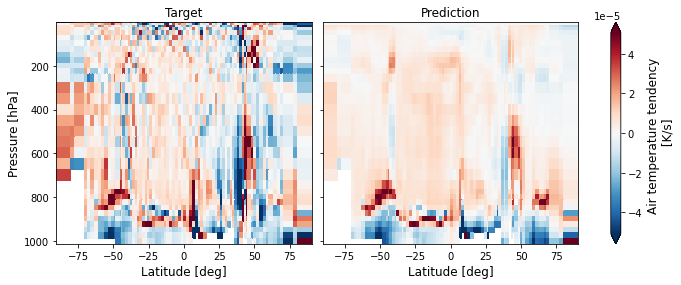

In [57]:
tq_transect.dQ1.attrs["units"] = "K/s"

f = plot_transect(tq_transect.dQ1.assign_coords({"pressure": pressure_hpa}))

f.axes.flat[0].set_title('Target', fontsize=12)
f.axes.flat[1].set_title('Prediction', fontsize=12)
f.axes.flat[0].set_ylabel('Pressure [hPa]', fontsize=12)
f.axes.flat[0].set_xlabel('Latitude [deg]', fontsize=12)
f.axes.flat[1].set_xlabel('Latitude [deg]', fontsize=12)
f.cbar.set_label("Air temperature tendency \n [K/s]", fontsize=12)

plt.savefig('figures/pdf/offline_dQ1_transect_lon0.pdf', dpi=150)
plt.savefig('figures/png/offline_dQ1_transect_lon0.png', dpi=150)


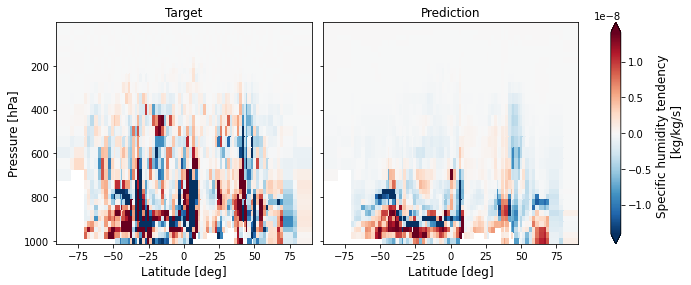

In [56]:
tq_transect.dQ2.attrs["units"] = "kg/kg/s"

f = plot_transect(tq_transect.dQ2.assign_coords({"pressure": pressure_hpa}))

f.axes.flat[0].set_title('Target', fontsize=12)
f.axes.flat[1].set_title('Prediction', fontsize=12)
f.axes.flat[0].set_ylabel('Pressure [hPa]', fontsize=12)
f.axes.flat[0].set_xlabel('Latitude [deg]', fontsize=12)
f.axes.flat[1].set_xlabel('Latitude [deg]', fontsize=12)
f.cbar.set_label("Specific humidity tendency \n [kg/kg/s]", fontsize=12)

plt.savefig('figures/pdf/offline_dQ2_transect_lon0.pdf', dpi=150)
plt.savefig('figures/png/offline_dQ2_transect_lon0.png', dpi=150)


#### Maps of time mean error in surface radiative fluxes

In [68]:
with fsspec.open(os.path.join(rad_results_path, 'scalar_metrics.json'), "r") as f:
    metrics = yaml.safe_load(f)
    

In [63]:
net_sw_bias = (
    rad_diags["net_shortwave_sfc_flux_via_transmissivity_time_mean_global"].sel(derivation="predict")
    - rad_diags["net_shortwave_sfc_flux_via_transmissivity_time_mean_global"].sel(derivation="target")
) 
downward_sw_bias = (
    rad_diags["downward_shortwave_sfc_flux_via_transmissivity_time_mean_global"].sel(derivation="predict")
    - rad_diags["downward_shortwave_sfc_flux_via_transmissivity_time_mean_global"].sel(derivation="target")
) 
downward_longwave_bias = (
    rad_diags["override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface_time_mean_global"].sel(derivation="predict")
    - rad_diags["override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface_time_mean_global"].sel(derivation="target")
)

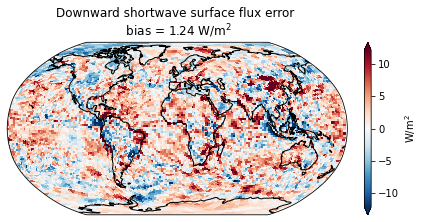

In [71]:
fv3viz.plot_cube(
    grid.merge(downward_sw_bias),
    "downward_shortwave_sfc_flux_via_transmissivity_time_mean_global", 
    cbar_label="W/m$^2$"
)
bias_sw_str = "%0.2f" % metrics["downward_shortwave_sfc_flux_via_transmissivity_bias_2d_global"]["mean"]

plt.title(f"Downward shortwave surface flux error \n bias = {bias_sw_str} W/m$^2$")
plt.tight_layout()
plt.savefig("figures/png/offline_downward_SW_error_map.png", dpi=150)
plt.savefig("figures/pdf/offline_downward_SW_error_map.pdf", dpi=150)

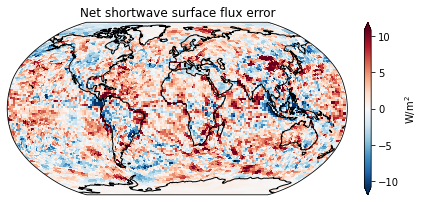

In [76]:
fv3viz.plot_cube(
    grid.merge(net_sw_bias),
    "net_shortwave_sfc_flux_via_transmissivity_time_mean_global", 
    cbar_label="W/m$^2$"
)


plt.title(f"Net shortwave surface flux error")
plt.tight_layout()
plt.savefig("figures/png/offline_net_SW_error_map.png", dpi=150)
plt.savefig("figures/pdf/offline_net_SW_error_map.pdf", dpi=150)

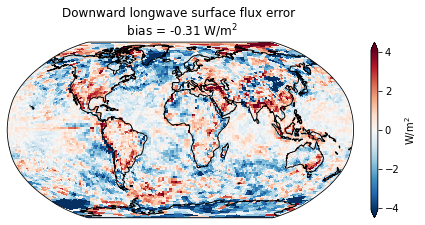

In [74]:
fv3viz.plot_cube(
    grid.merge(downward_longwave_bias),
    "override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface_time_mean_global", 
    cbar_label="W/m$^2$"
)

bias_lw_str = "%0.2f" % metrics["override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface_bias_2d_global"]["mean"]

plt.title(f"Downward longwave surface flux error \n bias = {bias_lw_str} W/m$^2$")
plt.tight_layout()

plt.savefig("figures/png/offline_downward_LW_error_map.png", dpi=150)
plt.savefig("figures/pdf/offline_downward_LW_error_map.pdf", dpi=150)